<a href="https://colab.research.google.com/github/kuds/apex/blob/main/%5BApex%5D%20Soft%20Actor-Critic%20(SAC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install stable-baselines3

In [3]:
import gymnasium
import mujoco
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_vec_env
import numpy
import os
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Tensorflow Version: {version('tensorflow')}")
print(f"tqdm Version: {version('tqdm')}")
print(f"MuJoCo Version: {version('mujoco')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.11.11
Torch Version: 2.5.1+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
Tensorflow Version: 2.18.0
tqdm Version: 4.67.1
MuJoCo Version: 3.3.0
Stable Baselines3 Version: 2.5.0


In [5]:
rl_type = "PPO"
env_str = "Apex-v1"
log_dir = "./logs/{}".format(env_str)
name_prefix = "apex"

In [6]:
# @title
xml_content = """
<mujoco model="humanoid">
    <compiler angle="degree" inertiafromgeom="true"/>
    <default>
        <joint armature="1" damping="1" limited="true"/>
        <geom conaffinity="1" condim="1" contype="1" margin="0.001" material="geom" rgba="0.8 0.6 .4 1"/>
        <motor ctrllimited="true" ctrlrange="-.4 .4"/>
    </default>
    <option integrator="RK4" iterations="50" solver="PGS" timestep="0.003">
        <!-- <flags solverstat="enable" energy="enable"/>-->
    </option>
    <size nkey="5" nuser_geom="1"/>
    <visual>
        <map fogend="5" fogstart="3"/>
    </visual>
    <asset>
        <texture builtin="gradient" height="100" rgb1=".4 .5 .6" rgb2="0 0 0" type="skybox" width="100"/>
        <!-- <texture builtin="gradient" height="100" rgb1="1 1 1" rgb2="0 0 0" type="skybox" width="100"/>-->
        <texture builtin="flat" height="1278" mark="cross" markrgb="1 1 1" name="texgeom" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture builtin="checker" height="100" name="texplane" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d" width="100"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>
    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom condim="3" friction="1 .1 .1" material="MatPlane" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="20 20 0.125" type="plane"/>
        <!-- <geom condim="3" material="MatPlane" name="floor" pos="0 0 0" size="10 10 0.125" type="plane"/>-->
        <body name="torso" pos="0 0 1.4">
            <camera name="track" mode="trackcom" pos="0 -4 0" xyaxes="1 0 0 0 0 1"/>
            <joint armature="0" damping="0" limited="false" name="root" pos="0 0 0" stiffness="0" type="free"/>
            <geom fromto="0 -.07 0 0 .07 0" name="torso1" size="0.07" type="capsule"/>
            <geom name="head" pos="0 0 .19" size=".09" type="sphere" user="258"/>
            <geom fromto="-.01 -.06 -.12 -.01 .06 -.12" name="uwaist" size="0.06" type="capsule"/>
            <body name="lwaist" pos="-.01 0 -0.260" quat="1.000 0 -0.002 0">
                <geom fromto="0 -.06 0 0 .06 0" name="lwaist" size="0.06" type="capsule"/>
                <joint armature="0.02" axis="0 0 1" damping="5" name="abdomen_z" pos="0 0 0.065" range="-45 45" stiffness="20" type="hinge"/>
                <joint armature="0.02" axis="0 1 0" damping="5" name="abdomen_y" pos="0 0 0.065" range="-75 30" stiffness="10" type="hinge"/>
                <body name="pelvis" pos="0 0 -0.165" quat="1.000 0 -0.002 0">
                    <joint armature="0.02" axis="1 0 0" damping="5" name="abdomen_x" pos="0 0 0.1" range="-35 35" stiffness="10" type="hinge"/>
                    <geom fromto="-.02 -.07 0 -.02 .07 0" name="butt" size="0.09" type="capsule"/>
                    <body name="right_thigh" pos="0 -0.1 -0.04">
                        <joint armature="0.01" axis="1 0 0" damping="5" name="right_hip_x" pos="0 0 0" range="-25 5" stiffness="10" type="hinge"/>
                        <joint armature="0.01" axis="0 0 1" damping="5" name="right_hip_z" pos="0 0 0" range="-60 35" stiffness="10" type="hinge"/>
                        <joint armature="0.0080" axis="0 1 0" damping="5" name="right_hip_y" pos="0 0 0" range="-110 20" stiffness="20" type="hinge"/>
                        <geom fromto="0 0 0 0 0.01 -.34" name="right_thigh1" size="0.06" type="capsule"/>
                        <body name="right_shin" pos="0 0.01 -0.403">
                            <joint armature="0.0060" axis="0 -1 0" name="right_knee" pos="0 0 .02" range="-160 -2" type="hinge"/>
                            <geom fromto="0 0 0 0 0 -.3" name="right_shin1" size="0.049" type="capsule"/>
                            <body name="right_foot" pos="0 0 -0.45">
                                <geom name="right_foot" pos="0 0 0.1" size="0.075" type="sphere" user="0"/>
                            </body>
                        </body>
                    </body>
                    <body name="left_thigh" pos="0 0.1 -0.04">
                        <joint armature="0.01" axis="-1 0 0" damping="5" name="left_hip_x" pos="0 0 0" range="-25 5" stiffness="10" type="hinge"/>
                        <joint armature="0.01" axis="0 0 -1" damping="5" name="left_hip_z" pos="0 0 0" range="-60 35" stiffness="10" type="hinge"/>
                        <joint armature="0.01" axis="0 1 0" damping="5" name="left_hip_y" pos="0 0 0" range="-110 20" stiffness="20" type="hinge"/>
                        <geom fromto="0 0 0 0 -0.01 -.34" name="left_thigh1" size="0.06" type="capsule"/>
                        <body name="left_shin" pos="0 -0.01 -0.403">
                            <joint armature="0.0060" axis="0 -1 0" name="left_knee" pos="0 0 .02" range="-160 -2" stiffness="1" type="hinge"/>
                            <geom fromto="0 0 0 0 0 -.3" name="left_shin1" size="0.049" type="capsule"/>
                            <body name="left_foot" pos="0 0 -0.45">
                                <geom name="left_foot" type="sphere" size="0.075" pos="0 0 0.1" user="0" />
                            </body>
                        </body>
                    </body>
                    <body name="tail" pos="0 0 0">
                        <joint armature="0.01" axis="0 1 0" damping="5" name="tail" pos="0 0 0" range="-25 25" stiffness="10" type="hinge"/>
                        <geom fromto="0 0 0 -.25 0 -.30" name="tail" size="0.05" type="capsule"/>
                    </body>
                </body>
            </body>
            <body name="right_upper_arm" pos="0 -0.17 0.06">
                <joint armature="0.0068" axis="2 1 1" name="right_shoulder1" pos="0 0 0" range="-85 60" stiffness="1" type="hinge"/>
                <joint armature="0.0051" axis="0 -1 1" name="right_shoulder2" pos="0 0 0" range="-85 60" stiffness="1" type="hinge"/>
                <geom fromto="0 0 0 .16 -.16 -.16" name="right_uarm1" size="0.04 0.16" type="capsule"/>
                <body name="right_lower_arm" pos=".18 -.18 -.18">
                    <joint armature="0.0028" axis="0 -1 1" name="right_elbow" pos="0 0 0" range="-90 50" stiffness="0" type="hinge"/>
                    <geom fromto="0.01 0.01 0.01 .17 .17 .17" name="right_larm" size="0.031" type="capsule"/>
                    <geom name="right_hand" pos=".18 .18 .18" size="0.04" type="sphere"/>
                    <camera pos="0 0 0"/>
                </body>
            </body>
            <body name="left_upper_arm" pos="0 0.17 0.06">
                <joint armature="0.0068" axis="2 -1 1" name="left_shoulder1" pos="0 0 0" range="-60 85" stiffness="1" type="hinge"/>
                <joint armature="0.0051" axis="0 1 1" name="left_shoulder2" pos="0 0 0" range="-60 85" stiffness="1" type="hinge"/>
                <geom fromto="0 0 0 .16 .16 -.16" name="left_uarm1" size="0.04 0.16" type="capsule"/>
                <body name="left_lower_arm" pos=".18 .18 -.18">
                    <joint armature="0.0028" axis="0 -1 -1" name="left_elbow" pos="0 0 0" range="-90 50" stiffness="0" type="hinge"/>
                    <geom fromto="0.01 -0.01 0.01 .17 -.17 .17" name="left_larm" size="0.031" type="capsule"/>
                    <geom name="left_hand" pos=".18 -.18 .18" size="0.04" type="sphere"/>
                </body>
            </body>
        </body>
    </worldbody>
    <tendon>
        <fixed name="left_hipknee">
            <joint coef="-1" joint="left_hip_y"/>
            <joint coef="1" joint="left_knee"/>
        </fixed>
        <fixed name="right_hipknee">
            <joint coef="-1" joint="right_hip_y"/>
            <joint coef="1" joint="right_knee"/>
        </fixed>
    </tendon>

    <actuator>
        <motor gear="100" joint="abdomen_y" name="abdomen_y"/>
        <motor gear="100" joint="abdomen_z" name="abdomen_z"/>
        <motor gear="100" joint="abdomen_x" name="abdomen_x"/>
        <motor gear="100" joint="right_hip_x" name="right_hip_x"/>
        <motor gear="100" joint="right_hip_z" name="right_hip_z"/>
        <motor gear="300" joint="right_hip_y" name="right_hip_y"/>
        <motor gear="200" joint="right_knee" name="right_knee"/>
        <motor gear="100" joint="left_hip_x" name="left_hip_x"/>
        <motor gear="100" joint="left_hip_z" name="left_hip_z"/>
        <motor gear="300" joint="left_hip_y" name="left_hip_y"/>
        <motor gear="200" joint="left_knee" name="left_knee"/>
        <motor gear="25" joint="right_shoulder1" name="right_shoulder1"/>
        <motor gear="25" joint="right_shoulder2" name="right_shoulder2"/>
        <motor gear="25" joint="right_elbow" name="right_elbow"/>
        <motor gear="25" joint="left_shoulder1" name="left_shoulder1"/>
        <motor gear="25" joint="left_shoulder2" name="left_shoulder2"/>
        <motor gear="25" joint="left_elbow" name="left_elbow"/>
        <motor gear="25" joint="tail" name="tail"/>
    </actuator>
</mujoco>
"""

with open("trex.xml", "w") as f:
    f.write(xml_content)

In [7]:
env = gymnasium.make('Humanoid-v5', xml_file="/content/trex.xml")
print("Observation Space Size: ", env.observation_space.shape)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  (373,)
Actions Space:  Box(-0.4, 0.4, (18,), float32)


In [8]:
# Create Training environment
env = make_vec_env(lambda : gymnasium.make('Humanoid-v5',
                                           xml_file="/content/trex.xml"), n_envs=4)

# Create Evaluation environment
env_val = make_vec_env(lambda : gymnasium.make('Humanoid-v5',
                                           xml_file="/content/trex.xml"), n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             render=False,
                             deterministic=True,
                             eval_freq=50_000)

# Create the SAC model
model = SAC(
    policy="MlpPolicy",  # Multi-layer perceptron policy
    env=env,
    verbose=0,
    learning_rate=0.0003,
    ent_coef=0.01,
    tensorboard_log=log_dir
)

# Train the model
time_steps = 5_000_000
model.learn(total_timesteps=time_steps,
            callback=eval_callback,
            progress_bar=True)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

env.close()
env_val.close()

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Eval num_timesteps=200000, episode_reward=512.44 +/- 87.88

Episode length: 188.40 +/- 31.19

New best mean reward!

Eval num_timesteps=400000, episode_reward=1356.48 +/- 767.36

Episode length: 502.40 +/- 265.49

New best mean reward!

Eval num_timesteps=600000, episode_reward=2707.45 +/- 73.41

Episode length: 982.40 +/- 35.20

New best mean reward!

Eval num_timesteps=800000, episode_reward=1407.71 +/- 1104.04

Episode length: 503.40 +/- 381.87

Eval num_timesteps=1000000, episode_reward=2378.93 +/- 550.45

Episode length: 844.40 +/- 200.59

Eval num_timesteps=1200000, episode_reward=2003.71 +/- 589.18

Episode length: 705.20 +/- 205.49

Eval num_timesteps=1400000, episode_reward=1795.93 +/- 833.73

Episode length: 614.00 +/- 284.16

Eval num_timesteps=1600000, episode_reward=2837.22 +/- 26.64

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=1800000, episode_reward=2818.59 +/- 171.03

Episode length: 989.00 +/- 22.00

Eval num_timesteps=2000000, episode_reward=1854.39 +/- 962.38

Episode length: 677.40 +/- 318.21

Eval num_timesteps=2200000, episode_reward=2819.00 +/- 6.61

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=2400000, episode_reward=2827.01 +/- 10.81

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=2600000, episode_reward=2686.91 +/- 490.98

Episode length: 918.20 +/- 163.60

Eval num_timesteps=2800000, episode_reward=2932.46 +/- 18.19

Episode length: 1000.00 +/- 0.00

New best mean reward!

Eval num_timesteps=3000000, episode_reward=2865.35 +/- 19.80

Episode length: 1000.00 +/- 0.00

Eval num_timesteps=3200000, episode_reward=2659.40 +/- 369.58

Episode length: 945.00 +/- 110.00

Eval num_timesteps=3400000, episode_reward=2594.60 +/- 817.81

Episode length: 867.60 +/- 264.80

Eval num_timesteps=3600000, episode_reward=3096.31 +/- 11.54

Episode length: 1000.00 +/- 0.00

New best mean reward!

KeyboardInterrupt: 

In [8]:
# Create Evaluation environment
env = gymnasium.make('Humanoid-v5', xml_file="/content/trex.xml", render_mode="rgb_array")
env = DummyVecEnv([lambda: env])

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = SAC.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
env = VecVideoRecorder(env, os.path.join(log_dir, "videos"),
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Best Model - Mean reward: 3081.12 +/- 14.45


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/logs/Apex-v1/videos/best_model_apex-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/logs/Apex-v1/videos/best_model_apex-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Apex-v1/videos/best_model_apex-step-0-to-step-10000.mp4


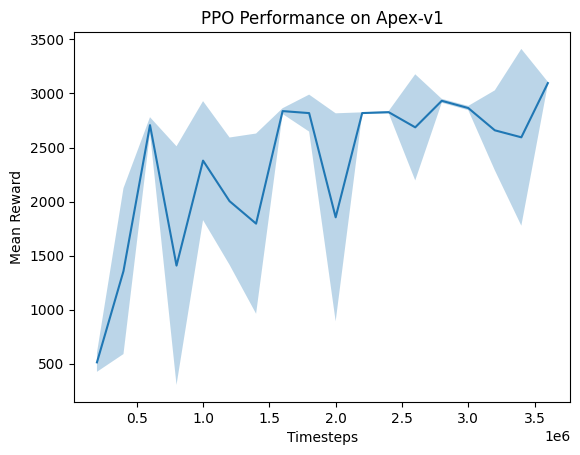

In [9]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()